100% (10999 of 10999) |##################| Elapsed Time: 0:01:52 Time:  0:01:52


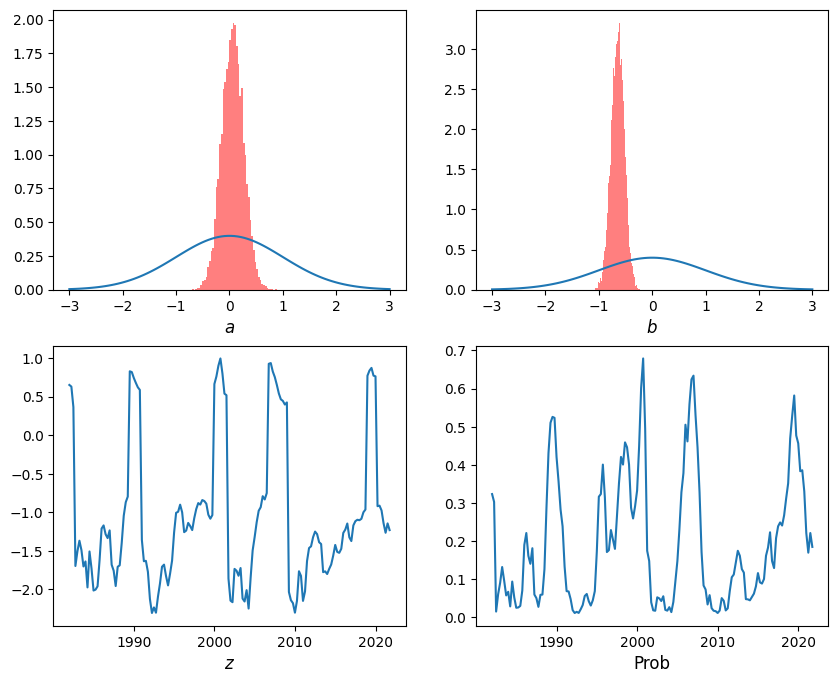

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
from progressbar import progressbar

"""
See also Peter Johansson & Andrew Meldrum (2018): Predicting Recession Probabilities Using the Slope of the Yield Curve, FEDS Notes
https://www.federalreserve.gov/econres/notes/feds-notes/predicting-recession-probabilities-using-the-slope-of-the-yield-curve-20180301.html
"""

# Binary probit linear regression
def probit(y, x, n, beta0, B0):
    # Initialization
    sample = {'beta': np.zeros((n, len(beta0))), 'z': np.zeros((n, len(y)))}
    sample['beta'][0, :] = beta0
    sample['z'][0, :] = 0
    B1 = np.linalg.inv(x.T @ x + np.linalg.inv(B0))
    
    # Sampling
    for i in progressbar(range(1, n)):
        beta1 = B1 @ (x.T @ sample['z'][i - 1, :].reshape(-1, 1) + np.linalg.inv(B0) @ beta0.reshape(-1,1))
        sample['beta'][i, :] = stats.multivariate_normal.rvs(size=1, mean=beta1.ravel(), cov=B1)
        
        m = x @ sample['beta'][i, :].reshape(-1, 1)
        for j in range(len(y)):
            if y[j] == 0:
                sample['z'][i, j] = stats.truncnorm.rvs(-1e3, -m[j], loc=m[j], scale=1, size=1)
            else:
                sample['z'][i, j] = stats.truncnorm.rvs(-m[j], 1e3, loc=m[j], scale=1, size=1)
        
    return sample

# Import recession data
with open("recession.csv", "r") as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

data = np.array(data, dtype=float)
date = data[:, header.index('Date')]
y = data[:, header.index('Recession')].reshape(-1, 1)
x = np.zeros((len(y), 2))
x[:, 0] = 1
x[:, 1] = data[:, header.index('Spread')]

# Prior and posterior
beta0 = np.array([0, 0])
B0 = np.array([[1, 0], [0, 1]])
sample = probit(y, x, 11000, beta0, B0)
sample['beta'] = sample['beta'][1000:11000, :]
sample['z'] = sample['z'][1000:11000, :]

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
beta1 = np.linspace(-3, 3, 100)
ax1.plot(beta1, stats.norm.pdf(beta1, loc=0, scale=1))
ax1.hist(sample['beta'][:, 0], bins=50, density=True, color="red", alpha=0.5)
ax1.set_xlabel(r'$a$', fontsize=12)
beta2 = np.linspace(-3, 3, 100)
ax2.plot(beta2, stats.norm.pdf(beta2, loc=0, scale=1))
ax2.hist(sample['beta'][:, 1], bins=50, density=True, color="red", alpha=0.5)
ax2.set_xlabel(r'$b$', fontsize=12)
ax3.plot(date, np.mean(sample['z'], axis=0))
ax3.set_xlabel(r'$z$', fontsize=12)
p = stats.norm.cdf(x @ np.mean(sample['beta'], axis=0).reshape(-1, 1))
ax4.plot(date, p)
ax4.set_xlabel('Prob', fontsize=12)
plt.show()

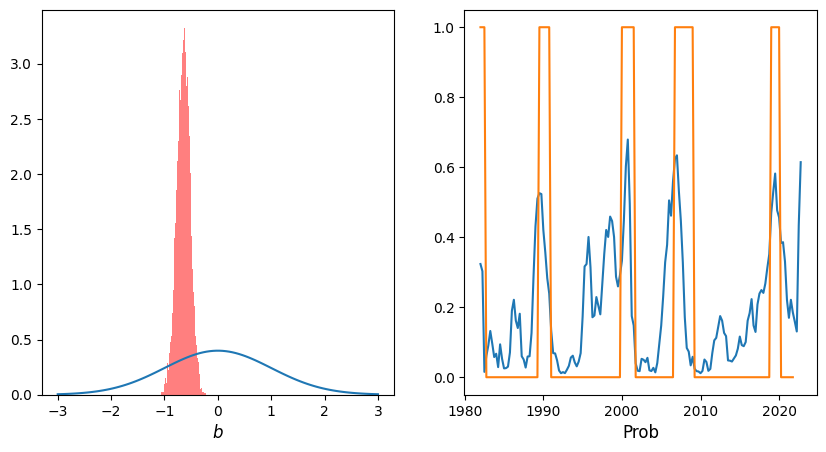

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
beta2 = np.linspace(-3, 3, 100)
ax1.plot(beta2, stats.norm.pdf(beta2, loc=0, scale=1))
ax1.hist(sample['beta'][:, 1], bins=50, density=True, color="red", alpha=0.5)
ax1.set_xlabel(r'$b$', fontsize=12)
date2 = np.append(date, [2022, 2022.25, 2022.5, 2022.75])
x2 = np.append(x, np.array([[1, 1.64], [1, 1.83], [1, 0.35], [1, -0.36]]), axis=0)
p2 = stats.norm.cdf(x2 @ np.mean(sample['beta'], axis=0).reshape(-1, 1))
ax2.plot(date2, p2)
ax2.plot(date, y)
ax2.set_xlabel('Prob', fontsize=12)
plt.show()